In [11]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from src.models.ecg_model import ECG_Model

In [ ]:
dt = 1e-4  # set time step
t = np.arange(0,10, dt)

plot_ecg [0.0000e+00 1.0000e-04 2.0000e-04 ... 9.9997e+00 9.9998e+00 9.9999e+00] [-0.00012    -0.00011908 -0.00011816 ...         nan         nan
         nan]


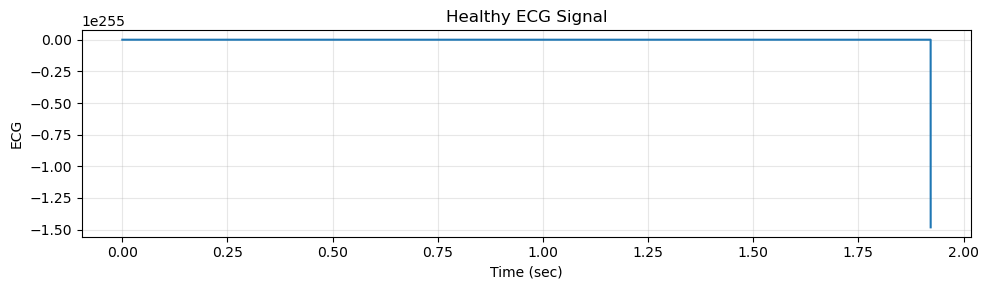

In [14]:
ecg = ECG_Model()
ECG_healthy, X_healthy = ecg.run(t, case='healthy')
# ECG_tachycardia, X_tachycardia = ecg.run(t, case='tachycardia')

In [4]:
# Baseline simulation using the ECG_Model class
dt = 1e-4
t = np.arange(0.0, 9.0, dt)
y0 = np.array([1e-4, 0.0, 1e-4, 0.0])

# Initialize the ECG_Model instance
ecg_model = ECG_Model()

X = ecg_model.rk4_boxed("healthy", y0, t, box=3.0)
print("X", X)

X [[1.00000000e-04 0.00000000e+00 1.00000000e-04 0.00000000e+00]
 [1.00070022e-04 8.39412511e-09 1.00070022e-04 8.39412511e-09]
 [1.00140086e-04 1.67765193e-08 1.00140086e-04 1.67765193e-08]
 ...
 [5.92917661e-02 7.40860252e-03 5.92917661e-02 7.40860252e-03]
 [5.93276832e-02 7.39845436e-03 5.93276832e-02 7.39845436e-03]
 [5.93636328e-02 7.38833018e-03 5.93636328e-02 7.38833018e-03]]


In [5]:

# Disregard initial transient and keep settled segment
mask = t >= 2.0
t_lc, X_lc = t[mask], X[mask]

# Optimize for speed
DECIM = 2
t_lc_d, X_lc_d = t_lc[::DECIM], X_lc[::DECIM]
dt_base = dt * DECIM

# PRC computation for x2
T2, tref2, _ = ecg_model.period_and_tref(X_lc_d[:, 1], t_lc_d, dt_base)
ph2, dph2 = ecg_model.prc_xcorr(ecg_model.ecg_rhs, None, t_lc_d, X_lc_d, T2, tref2,
                      var_index=1, steps=120, amp_rel=0.02,
                      dt_base=dt_base, dt_prc=4e-4, window_cycles=1.2)

# PRC computation for x4
T4, tref4, _ = ecg_model.period_and_tref(X_lc_d[:, 3], t_lc_d, dt_base)
ph4, dph4 = ecg_model.prc_xcorr(ecg_model.ecg_rhs, None, t_lc_d, X_lc_d, T4, tref4,
                      var_index=3, steps=120, amp_rel=0.02,
                      dt_base=dt_base, dt_prc=4e-4, window_cycles=1.2)

# Shift adjustments
ph2a, dph2a = ecg_model.shift_only(ph2, dph2, target_min=0.18, target_pos=0.32)
ph4a, dph4a = ecg_model.shift_only(ph4, dph4, target_min=0.20)

FLIP_X2 = True
if FLIP_X2:
    dph2a = -(dph2a - dph2a.mean())

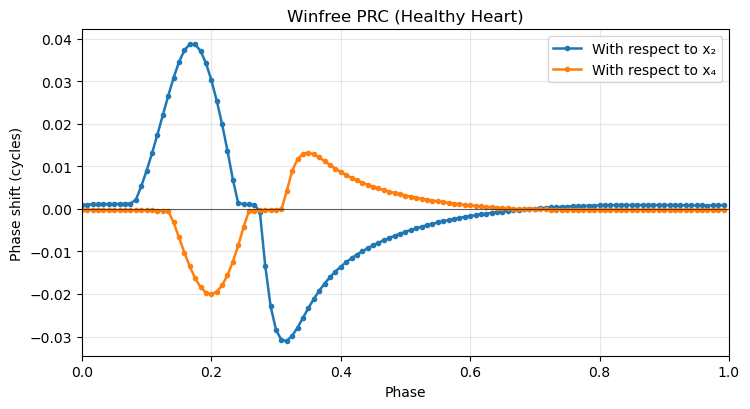

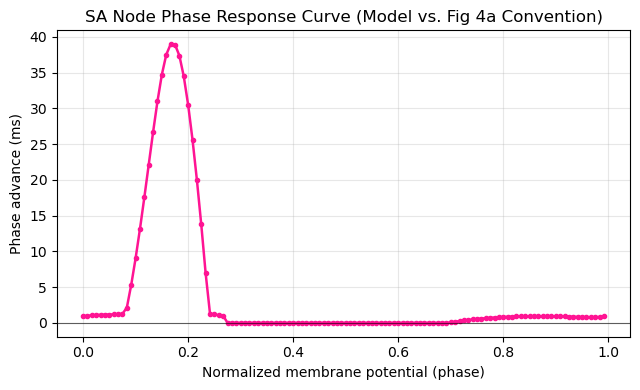

PRC from Winfree model was modeled in physiological terms (x-axis: normalized membrane potential during cycle,, y-axis: converted from cycles to milliseconds of phase advance. As the experiment depicted disregarding negative shifts, these were omitted. The resulting PRC depicts an early peak at ~0.2 cycle, and subsequent;y decays to 0 in late phase. Both curves suggest early-cycle stimuli accelerate next beat most significantly, while late-cycle stimuli have more insignificant affects due to refractoriness.


In [10]:
# PRC plot
from src.utils.plotting import plot_prc, plot_phase_advance

# Call the plot_prc function
plot_prc(ph2a, dph2a, ph4a, dph4a)

# Phase advance plot
T_ms = T2 * 1000        # Convert phase shift to milliseconds
advance_ms = dph2a * T_ms       # phase advance in ms
advance_ms = np.clip(dph2a, 0, None) * T_ms     # only positive = depolarizing advance
plot_phase_advance(ph2a, advance_ms)

print("PRC from Winfree model was modeled in physiological terms (x-axis: normalized membrane potential during cycle,, y-axis: converted from cycles to milliseconds of phase advance. As the experiment depicted disregarding negative shifts, these were omitted. The resulting PRC depicts an early peak at ~0.2 cycle, and subsequent;y decays to 0 in late phase. Both curves suggest early-cycle stimuli accelerate next beat most significantly, while late-cycle stimuli have more insignificant affects due to refractoriness.")